In [1]:
!pip install scipy numpy pandas

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

##  Исходные данные
Я не до конца понял само задание с рисками, надо было выбрать из 4 направлений - лучший или посчитать как распределить свой портфель среди всех.

In [3]:
initial_capital = 1000000
years = 3
risk_free_rate = 0.05

asset_details = {
    'Акции': {
        'return': 0.20,
        'risk_coeff': 0.5,
        'bounds': (0.10, 0.40)
    },
    'Облигации': {
        'return': 0.11,
        'risk_coeff': 0.1,
        'bounds': (0.20, 0.80)
    },
    'ПИФы': {
        'return': 0.15,
        'risk_coeff': 0.25,
        'bounds': (0.10, 0.70)
    },
    'Стартап друга': {
        'return': 1.00,
        'risk_coeff': 0.9,
        'bounds': (0.00, 0.30)
    }
}

In [4]:
asset_names = list(asset_details.keys())

In [5]:
# asset_names

In [6]:
returns = np.array([asset_details[asset]['return'] for asset in asset_names])
risk_coeffs = np.array([asset_details[asset]['risk_coeff'] for asset in asset_names])
bounds = [asset_details[asset]['bounds'] for asset in asset_names]


In [7]:
#returns

In [8]:
#risk_coeffs

In [9]:
#bounds

In [10]:
cov_matrix = np.diag(risk_coeffs ** 2)

In [11]:
#cov_matrix

## Так как я решил использовать Коэффициент Шарпа:
Коэффициент Шарпа — показатель эффективности инвестиционного портфеля, который вычисляется как отношение средней премии за риск к среднему отклонению портфеля.
# Коэффициент Шарпа (Sharpe Ratio)

Формула коэффициента Шарпа:

$$
S = \frac{R_p - R_f}{\sigma_p}
$$

**где:**
- $R_p$ - ожидаемая доходность портфеля
- $R_f$ - безрисковая ставка доходности (например, доходность по государственным облигациям)
- $\sigma_p$ - стандартное отклонение доходности портфеля (риск)

# Интерпретация коэффициента Шарпа:

- 1.0: Отличное соотношение риск/доходность

- 0.5-1.0: Хорошее соотношение

- <0.5: Неоптимальное соотношение

In [12]:
def portfolio_return(weights):
    """Ожидаемая доходность портфеля"""
    return np.sum(weights * returns)

def portfolio_risk(weights):
    """Риск портфеля (стандартное отклонение)"""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights):
    """Отрицательный коэффициент Шарпа (для минимизации)"""
    ret = portfolio_return(weights)
    risk = portfolio_risk(weights)
    if risk < 1e-10:
        return np.inf
    return -ret / risk  # отрицательное значение для минимизации

Ну и оптимизируем  по минимизации коээфа Шарпа c помощью SLSQP - наименьших квадратов

In [13]:
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
)

initial_weights = np.ones(len(asset_names)) / len(asset_names)

result = minimize(
    fun=negative_sharpe_ratio,
    x0=initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,

)

In [14]:
if not result.success:
    raise ValueError(f"Оптимизация не удалась: {result.message}")

In [15]:
optimal_weights = result.x
cleaned_weights = {asset: weight for asset, weight in zip(asset_names, optimal_weights)}

## Посчитаем нашу выгоду и риски

In [16]:
expected_return = portfolio_return(optimal_weights)
portfolio_vol = portfolio_risk(optimal_weights)
sharpe_ratio = (expected_return - risk_free_rate ) / portfolio_vol

In [17]:
final_capital = initial_capital * (1 + expected_return) ** years
profit = final_capital - initial_capital

## Мне захотелось все это красиво вывести

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## Табличками

In [19]:
weights_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['Доля'])
weights_df['Процент'] = weights_df['Доля'].apply(lambda x: f"{x*100:.2f}%")

In [20]:
plot_df = pd.DataFrame({'Актив': weights_df.index, 'Доля': [x for x in cleaned_weights.values()]})

In [21]:
def format_currency(x):
    return f"{x:,.2f} руб.".replace(',', ' ')

In [22]:
results = {
    "Начальный капитал": format_currency(initial_capital),
    "Прогнозируемый капитал через 3 года": format_currency(final_capital),
    "Прогнозируемая прибыль": format_currency(profit),
    "Ожидаемая годовая доходность": f"{expected_return*100:.2f}%",
    "Ожидаемая годовая волатильность": f"{portfolio_vol*100:.2f}%",
    "Коэффициент Шарпа": f"{sharpe_ratio:.2f}"
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Значение'])

In [23]:
display(HTML("<h2>Оптимальное распределение средств:</h2>"))
display(weights_df[['Процент']].rename(columns={'Процент': 'Доля'}))

display(HTML("<h2>Характеристики портфеля:</h2>"))
display(results_df)

,Доля
Акции,10.00%
Облигации,66.22%
ПИФы,15.14%
Стартап друга,8.64%


,Значение
Начальный капитал,1 000 000.00 руб.
Прогнозируемый капитал через 3 года,1 736 257.58 руб.
Прогнозируемая прибыль,736 257.58 руб.
Ожидаемая годовая доходность,20.19%
Ожидаемая годовая волатильность,11.98%
Коэффициент Шарпа,1.27


## Графики

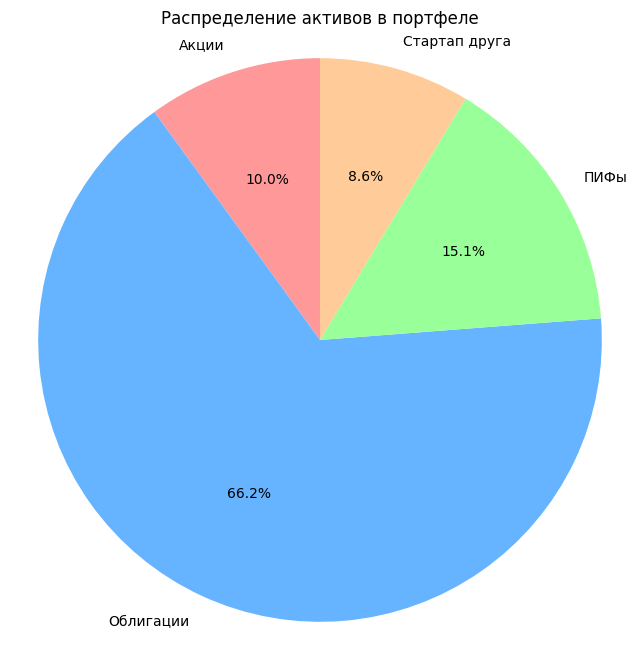

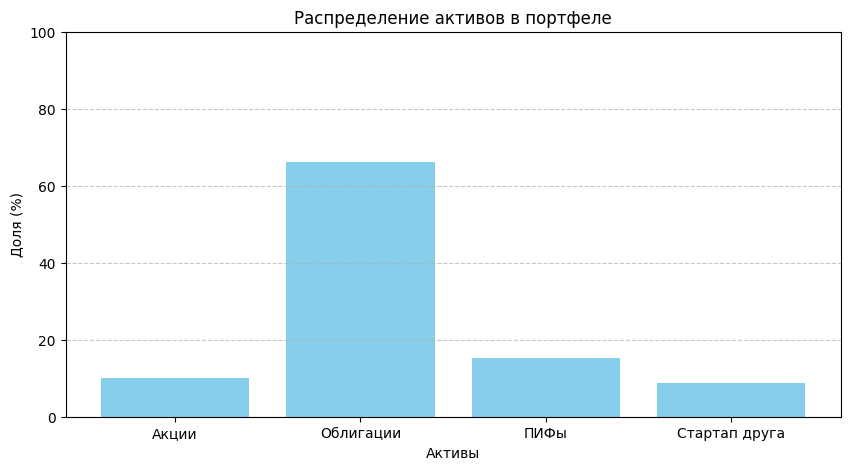

In [24]:
display(HTML("<h3>Графическое представление распределения:</h3>"))
plt.figure(figsize=(8, 8))
plt.pie(
    plot_df['Доля'],
    labels=plot_df['Актив'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99']
)
plt.axis('equal')
plt.title('Распределение активов в портфеле')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(plot_df['Актив'], plot_df['Доля']*100, color='skyblue')
plt.xlabel('Активы')
plt.ylabel('Доля (%)')
plt.title('Распределение активов в портфеле')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()